# Assignment 2 - Epipolar Geometry and 3D Reconstruction 

First name:
<br>
Last name: 
<br>
Matriculation number:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

import numpy as np
from PIL import Image
#import ipyvolume as ipv
import matplotlib.pyplot as plt

from utils import decompose_essential_matrix, infer_3d, ransac, get_essential_matrix

## Part II: 3D Model Reconstruction

### Load matched points
We provide a synthetic pair of images where noisy correspondences are known.

In [2]:
left = np.array(Image.open(os.path.join('MatchedPoints','left.jpg')), dtype=np.float32).mean(2)/255
right = np.array(Image.open(os.path.join('MatchedPoints','right.jpg')), dtype=np.float32).mean(2)/255

Text(0.5, 1.0, 'Right image')

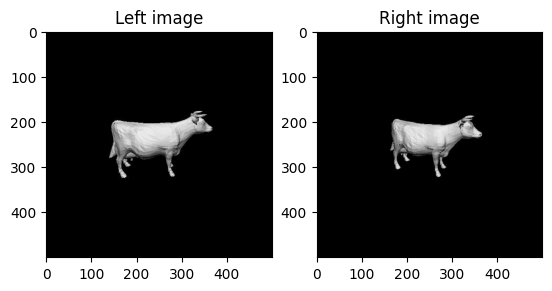

In [3]:
plt.subplot(1,2,1)
plt.imshow(left, cmap='gray')
plt.title('Left image')
plt.subplot(1,2,2)
plt.imshow(right, cmap='gray')
plt.title('Right image')

In [4]:
ilias_username = "f.alice" #The ilias username is a.fornaciari
A = np.loadtxt(f'MatchedPoints/Matched_Points_{ilias_username}.txt')

In [5]:
M, N = A.shape
leftPoints = np.concatenate((A[:,2:4].T, np.ones((1, M))), axis=0)
rightPoints = np.concatenate((A[:,0:2].T, np.ones((1, M))), axis=0)

### Calibration matrix and focal length from the given file

In [6]:
fl = 4
K = np.array([
    [-83.33333, 0.00000, 250.00000],
    [0.00000, -83.33333, 250.00000],
    [0.00000, 0.00000,   1.00000],
])

I = K.copy()

I[0,0] *= fl
I[1,1] *= fl

### Estimate Essential matrix E from F with RANSAC

The 8-point algorithm assumes that all entries are independent from one another.
Matrix E has 9 unknown entries but one can be derived from the other 8.
For 'n' points is possible to write an homogeneous system of n equations 
--> in this case to derive non trivial solutions for QE=0 -->(x'^T) * E * x=0 (Q same role as A for F)
I need at least 8 point correspondences, each one providing one independent equation
--> If I know the calibration matrices of the two cameras, I can estimate the essential matrix: E = K2^T*F*K1, inverse approach where:
- K1, internal camera calibration matrix of camera 1 --> x1_n=K^-1 * x1
- K2, internal camera calibration matrix of camera 2


In [14]:
# prob_inl = 0.95
# N = leftPoints.shape[1]
good_threshold = 1e-2 # or 0.1 # TODO FOR EXAMPLE
F, inliers = ransac(leftPoints, rightPoints, good_threshold)  
print("norm of F =", np.linalg.norm(F))
print("Num inliers = ", inliers.shape[-1])
print('Num outliers', leftPoints.shape[1] - inliers.shape[-1])
assert np.linalg.matrix_rank(F) == 2
print('Estimated fundamental matrix: ')
print(F)

# TODO: Estimate essential matrix E from F
#K1 and K2 are the intrinsics of the two cameras
#intrinsics = np.load('Intrinsic/and/extrinsic/parameters.rtf')#('../data/intrinsics.npz')
#K1 = intrinsics['K1'] -->K1 = x1_n^(-1) *x1
#K2 = intrinsics['K2'] --> K2 = x2_n^(-1) *x2
#K1 = K2= K
E = get_essential_matrix(F, K, K)

print('Estimated essential matrix: ')
print(E)

norm of F = 0.5442058629640847
Num inliers =  9423
Num outliers 3167
Estimated fundamental matrix: 
[[ 1.68815998e-05 -1.03567731e-04  1.84671230e-02]
 [ 7.29042891e-05  2.22822652e-05  1.08808330e-03]
 [-1.65154350e-02 -3.27408153e-03 -5.43630671e-01]]
Estimated essential matrix: 
[[ 0.11723332 -0.71922029  0.26703413]
 [ 0.50627974  0.15473794 -2.07372674]
 [-0.49425308  1.96628725 -0.07093177]]


### Compute rotation and translation between views

In [15]:
# TODO: Compute rotation and translation between views. Complete decomposeE --> in utils.py
Il = np.linalg.solve(I, leftPoints)
Ir = np.linalg.solve(I, rightPoints)

Pl, Pr = decompose_essential_matrix(E, Il, Ir)

print('Estimated translation: ')
print(Pr[:,3])
print('Estimated rotation: ')
print(Pr[:,:3])

Estimated translation: 
[-0.93627615 -0.10914414 -0.33387801]
Estimated rotation: 
[[ 0.          0.11459699  0.        ]
 [-0.24020442 -0.         -0.        ]
 [-0.         -0.          0.08251998]]


### Estimate the 3D points

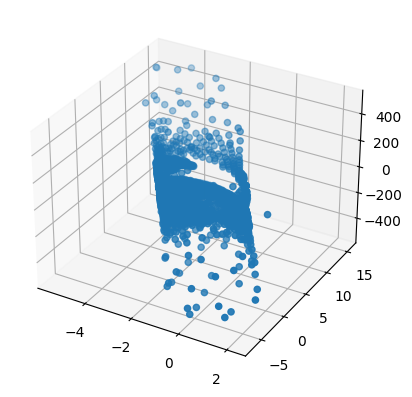

In [16]:
x3D = infer_3d(Il, Ir, Pl, Pr)
#ipv.quickscatter(x=x3D[0,:], y=x3D[1,:], z=x3D[2,:])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs=x3D[0,:], ys=x3D[1,:], zs=x3D[2,:])
